In [113]:
import numpy
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# **True Stories**

## General Properties

In [114]:
mechanical_eff = 0.99
gamma_air = 1.4
gamma_g = 1.33333
c_p_air = 1.005
c_p_gas = 1.148

In [115]:
m_cool_vane_hpt = 0.1450776
m_cool_disc_hpt = 0.0797

#### Temperature and Pressure Calculations
From part A cycle calculations.

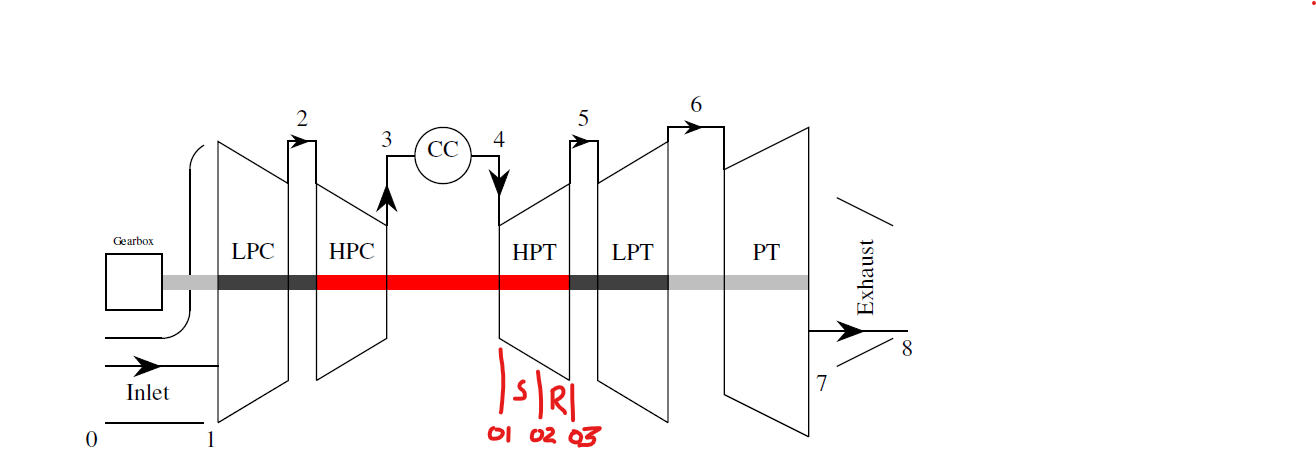

Turbine Station 1 -> INLET
Turbine Station 2 -> BETWEEN ROTOR AND STATOR


1. C -> Absolute Velocity 
2. V -> Relative Velocity 
3. C_a -> Axial Velocity 

M_1 -> Absolute Mach Number

M_1_rel -> Relative Mach Number

In [116]:
# TURBINE INLET
T_01 = 1245.320         # [k]
P_01 = 1182.073         # [kPa]
m_dot_1 = 4.835922
M_1 = 0.125

# BETWEEN STATOR AND ROTOR
m_dot_2 = m_dot_1 + m_cool_vane_hpt

# TURBINE EXIT
T_03 = 1053.051
P_03 = 524.594
m_dot_3 = m_dot_2 + m_cool_disc_hpt

In [128]:
T_3 = 1021
P_3 = 496.6
R = 0.287


def calc_properties(M, T_stagnation, P_stagnation):
    T = T_stagnation/(1 + ((gamma_g - 1)/2) * M**2)
    P = P_stagnation/((1 + ((gamma_g - 1)/2) * M**2))**(gamma_g/(gamma_g - 1))
    print(T, P)
    return T, P

T_1, P_1 = calc_properties(0.425, T_03, P_03)

rho1 = P_1/(T_1 * R)
rho3 = P_3/(R * T_3)

C_1 = 0.125 * numpy.sqrt(gamma_g * R*1000 *  T_1)
C_a_1 = numpy.cos(numpy.radians(10)) * C_1

1022.276524863905 465.90660239981776


## Define Ranges

Define the range for the stage loading coefficient, flow coefficient and the reaction. Using the obtained values, calculate the other values.

Use the following data:
1. Stage Loading Coefficient ($\psi$) -> 3.0 - 5.0
2. Reaction ($\Lambda$) -> 0.35 - 0.65
3. Flow Coefficient ($\phi$) -> 0.6 - 1.0
4. Structural Limit ($AN^2$) -> 10000000 - 22580600 (checking for a wide range)
5. Zweifel for vane -> 0.75 - 0.90
6. Zweifel for rotor -> 0.80 - 0.95

In [118]:
range_flow_coefficient_5 = numpy.linspace(0.4, 0.7, 40)
range_degree_reaction = numpy.linspace(0.35, 0.6, 40)
range_stage_loading = numpy.linspace(1, 5, 40)          # Original -> 3 - 5
range_AN_squared = numpy.linspace(10000000, 22580600, 10)
range_zweifel_vane = numpy.linspace(0.75, 0.90, 15)
range_zweifel_rotor = numpy.linspace(0.80, 0.95, 15)

## General Approach Functions
The following approach is used ->
1. Calculate beta_3 and alpha_3 based on reaction, flow coefficient and stage loading.
2. Calculating U for all the flow coefficients.
3. Calculate the exit axial and absolute velocities, while eliminating the values not needed.

In [119]:
def calc_angles(reaction, psi, phi):
    """
    This function calculates the angles obtained.
    Input: Degree of reaction "lambda", flow coefficient "phi", blade loading coefficient "psi"
    Output: Returns the value of the exit swirl angle.
    """
    tan_beta_3 = (0.5 / phi) * (0.5 * psi + 2 * reaction)
    alpha_3 = numpy.rad2deg(numpy.arctan(tan_beta_3 - (phi**(-1))))
    return alpha_3

def calc_U(psi):
    """
    This function calculates the metal speed U.
    Input:  Stage loading coefficient "psi"
    Output: Returns the value of U
    """
    U = numpy.sqrt((2*c_p_gas*1000*(T_01 - T_03)) / (psi))    
    return U

def calc_absolute_exit_velocity(angle_pointer, vel_axial):
    """
    This function calculates the absolute exit velocity.
    Input:  Exit swirl angle "alpha_3", absolute exit velocity "c_5"
    Output: Returns the absolute exit axial velocity "c_a_5"
    """
    c_abs = vel_axial/(numpy.cos(numpy.radians(angle_pointer)))
    return c_abs

def calc_stage_2(psi_pointer, phi_pointer, alpha_pointer, axial_vel_pointer):
    """
    This function calculates the gas and metal angles between the vane and the rotor.
    Input:  Flow coefficient "phi", blade loading coefficient "psi", Exit swirl angle "alpha_3"
    Output: Returns the gas and metal angles "alpha_2" and "beta_2", tangential velocity "c_w_2", relative velocity "v_2" and absolute velocity "c_2"
    """
    alpha_2 = numpy.rad2deg(numpy.arctan((psi_pointer/(2 * phi_pointer)) - numpy.tan(numpy.radians(alpha_pointer))))
    beta_2 = numpy.rad2deg(numpy.arctan(numpy.tan(numpy.radians(alpha_2)) - phi_pointer**(-1)))
    c_w_2 = axial_vel_pointer * numpy.tan(numpy.radians(alpha_2))
    v__ = axial_vel_pointer/(numpy.cos(numpy.radians(beta_2)))
    c__ = axial_vel_pointer/(numpy.cos(numpy.radians(alpha_2)))
    return alpha_2, beta_2, c_w_2, v__, c__

def calc_areas(C_a_3):
    """
    Calculate areas based on different flow coefficients
    """
    A1 = m_dot_1/(rho1 * C_a_1)
    A3 = m_dot_2 /(rho3 * C_a_3)
    A2 = A3
    return A1, A2, A3

def calc_structural(an_squared_pointer, area_2_pointer, U_meanline_pointer):
    N = numpy.sqrt((an_squared_pointer)/area_2_pointer)
    omega = N*2*numpy.pi/60
    r_meanline = U_meanline_pointer/omega
    h = (area_2_pointer * (N/60))/U_meanline_pointer
    r_hub = r_meanline - (h/2)
    r_tip = r_meanline + (h/2)
    return N, omega, r_hub, r_tip, r_meanline, h

Once the shaft the speed is delivered by the the compressor work pack, the value of U can be decided and filtered out.

## Area and Blade Height


#### Free Vortex

In [120]:
def calc_free_vortex(r_pointer, U_pointer, psi_pointer, phi_pointer, C_a_3_pointer):
    A1, A2, A3 = calc_areas(C_a_3_pointer)
    T2_temp = T_3 + r_pointer *(T_1-T_3)
    P2_temp = P_3 * (T2_temp/T_3)**(gamma_g/(gamma_g-1))
    rho2_temp = P2_temp/(R*T2_temp) 
    C_a_45 = m_dot_2/(rho2_temp*A2)
 
    flow_coefficient_2 = C_a_45/U_pointer
    beta_3 = numpy.rad2deg(numpy.arctan(0.5/phi_pointer*(0.5*psi_pointer+2*r_pointer)))
    beta_2 = numpy.rad2deg(numpy.arctan(0.5/phi_pointer*(0.5*psi_pointer-2*r_pointer)))

    # This is for alpha_2 -> between rotor and stator
    C2 = numpy.sqrt(C_a_45**2 + (C_a_45 * numpy.tan(numpy.radians(beta_2)) + U_pointer)**2)
    alpha_2 = numpy.rad2deg(numpy.arctan((C_a_45 * numpy.tan(numpy.radians(beta_2)) + U_pointer)/C_a_45))
    V2 = C_a_45 /(numpy.cos(numpy.radians(beta_2)))
    
    # This is for alpha_3 -> between rotor and stator
    C3 = numpy.sqrt(C_a_3_pointer**2 + (C_a_3_pointer * numpy.tan(numpy.radians(beta_3)) - U_pointer)**2)
    alpha_3 = numpy.rad2deg(numpy.arctan((C_a_3_pointer * numpy.tan(numpy.radians(beta_3)) - U_pointer)/C_a_3_pointer))
    V3 = C_a_3_pointer /(numpy.cos(numpy.radians(beta_3)))

    return A1, A2, A3, flow_coefficient_2, C2, C_a_45,V2, alpha_2, beta_2, C3, V3, alpha_3, beta_3


def calc_hub_angles(r_m_pointer, r_hub_pointer, alpha_2_pointer, alpha_3_pointer, flow_coeff_2_pointer, flow_coeff_3_pointer, U_pointer):
        alpha_2_hub_rad = numpy.arctan((r_m_pointer/r_hub_pointer) *numpy.tan(numpy.deg2rad(alpha_2_pointer)))
        alpha_2_hub_deg = numpy.rad2deg(alpha_2_hub_rad)
    
        alpha_3_hub_rad = numpy.arctan((r_m_pointer/r_hub_pointer) *numpy.tan(numpy.deg2rad(alpha_3_pointer)))
        alpha_3_hub_deg = numpy.rad2deg(alpha_3_hub_rad)
    
        beta_2_hub_rad = numpy.arctan((r_m_pointer/r_hub_pointer) *numpy.tan(numpy.deg2rad(alpha_2_pointer)) - (r_hub_pointer/r_m_pointer)*(flow_coeff_2_pointer)**(-1))
        beta_2_hub_deg = numpy.rad2deg(beta_2_hub_rad)
    
        beta_3_hub_rad = numpy.arctan((r_m_pointer/r_hub_pointer) *numpy.tan(numpy.deg2rad(alpha_3_pointer)) + (r_hub_pointer/r_m_pointer)*(flow_coeff_3_pointer)**(-1))
        beta_3_hub_deg = numpy.rad2deg(beta_3_hub_rad)

        U_hub = U_pointer * (r_hub_pointer / r_m_pointer)

        return alpha_2_hub_deg, alpha_3_hub_deg, beta_2_hub_deg, beta_3_hub_deg,  U_hub

def calc_tip_angles(r_m_pointer, r_tip_pointer, alpha_2_pointer, alpha_3_pointer, flow_coeff_2_pointer, flow_coeff_3_pointer, U_pointer):
        alpha_2_tip_rad = numpy.arctan((r_m_pointer/r_tip_pointer) *numpy.tan(numpy.deg2rad(alpha_2_pointer)))
        alpha_2_tip_deg = numpy.rad2deg(alpha_2_tip_rad)
    
        alpha_3_tip_rad = numpy.arctan((r_m_pointer/r_tip_pointer) *numpy.tan(numpy.deg2rad(alpha_3_pointer)))
        alpha_3_tip_deg = numpy.rad2deg(alpha_3_tip_rad)
    
        beta_2_tip_rad = numpy.arctan((r_m_pointer/r_tip_pointer) *numpy.tan(numpy.deg2rad(alpha_2_pointer)) - (r_tip_pointer/r_m_pointer)*(flow_coeff_2_pointer)**(-1))
        beta_2_tip_deg = numpy.rad2deg(beta_2_tip_rad)
    
        beta_3_tip_rad = numpy.arctan((r_m_pointer/r_tip_pointer) *numpy.tan(numpy.deg2rad(alpha_3_pointer)) + (r_tip_pointer/r_m_pointer)*(flow_coeff_3_pointer)**(-1))
        beta_3_tip_deg = numpy.rad2deg(beta_3_tip_rad)    

        U_tip = U_pointer * (r_tip_pointer / r_m_pointer)

        return alpha_2_tip_deg, alpha_3_tip_deg, beta_2_tip_deg, beta_3_tip_deg, U_tip

def calc_tip_hub_reaction(c_a_3_pointer, c_a_2_pointer ,beta_2_hub, beta_2_tip, beta_3_hub, beta_3_tip, U_hub, U_tip):

        reaction_hub = (c_a_3_pointer * numpy.tan(numpy.deg2rad(beta_3_hub)) - c_a_2_pointer*numpy.tan(numpy.deg2rad(beta_2_hub)))/(2*U_hub)
        reaction_tip = (c_a_3_pointer * numpy.tan(numpy.deg2rad(beta_3_tip)) - c_a_2_pointer*numpy.tan(numpy.deg2rad(beta_2_tip)))/(2*U_tip)

        return reaction_hub, reaction_tip

#### Area Calculatations
These are based on the use of values given for structural limit.
$$r_{tip} = \sqrt{\frac{A}{\pi} + r_{hub}^2}$$

## Aerodynamic Losses

In [121]:
class aerodynamic_losses():
    """
    Profile losses calculated in this class.
    """
    class profile_losses():
        """
        Profile losses calculated in this class.
        """
        def figure_2_3a(pitch_chord_ratio, exit_flow_angle):
            fig_2_3a = pd.read_csv(r'_input_database\figure_2_3a.csv')
            X = fig_2_3a[['pitch_chord_ratio', 'exit_flow_angle']]
            y = fig_2_3a['K_P_1']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            model = LinearRegression()
            model.fit(X_train, y_train)

            X = pd.DataFrame({'pitch_chord_ratio': [pitch_chord_ratio], 'exit_flow_angle': [exit_flow_angle]})
            K_P_1 = model.predict(X)
            
            return K_P_1[0]
    
        def figure_2_3b(pitch_chord_ratio, exit_flow_angle):
            fig_2_3b = pd.read_csv(r'_input_database\figure_2_3b.csv')
            X = fig_2_3b[['pitch_chord_ratio', 'exit_flow_angle']]
            y = fig_2_3b['K_P_2']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            model = LinearRegression()
            model.fit(X_train, y_train)

            X = pd.DataFrame({'pitch_chord_ratio': [pitch_chord_ratio], 'exit_flow_angle': [exit_flow_angle]})
            K_P_2 = model.predict(X)
            
            return K_P_2[0]
         
        def figure_2_4(beta_b1, beta_b2):
            beta_eff = beta_b1 + beta_b2
            fig_2_4 = pd.read_csv(r'_input_database\figure_2_4.csv')
            X = fig_2_4[['beta_b1_b2']]
            y = fig_2_4['tmax_and_c']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            model = LinearRegression()
            model.fit(X_train, y_train)

            X = pd.DataFrame({'beta_b1_b2': [beta_eff]})
            tmax_and_c = model.predict(X)
            
            return tmax_and_c[0]
        
        def figure_2_5(beta_b1, beta_b2):
            fig_2_5 = pd.read_csv(r'_input_database\figure_2_5.csv')
            X = fig_2_5[['beta_b1', 'beta_b2']]
            y = fig_2_5['Stagger Angle']

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            model = LinearRegression()
            model.fit(X_train, y_train)

            X = pd.DataFrame({'beta_b1': [beta_b1], 'beta_b2': [beta_b2]})
            stagger_angle = model.predict(X)
            
            return stagger_angle[0]
        
        
        def figure_2_6(x_value, x=True):
            """
            x = True for Rotor
            """
            fig_2_6 = pd.read_csv(r'_input_database\figure_2_6.csv')
            rhrt = fig_2_6['x'].values
            y1 = fig_2_6['Rotor'].values
            y2 = fig_2_6['Nozzle'].values

            if x == True:
                interp_func = interp1d(rhrt, y1, kind='cubic')
                interpolated_y = interp_func(x_value)
            else:
                interp_func = interp1d(rhrt, y2, kind='cubic')
                interpolated_y = interp_func(x_value)
            
            return interpolated_y

        def figure_2_7(x_value):

            fig_2_7 = pd.read_csv(r'_input_database\figure_2_7.csv')
            x = fig_2_7['M_1_hub'].values
            y = fig_2_7['delta_p_q_1_hub'].values

            interp_func = interp1d(x, y, kind='cubic')
            interpolated_y = interp_func(x_value)
            
            return interpolated_y


        """
        The following section give information about the symbols to be used for the following class.
        This is established from the information provided in Axial and Radial Turbines Part A - Moustapha.
        """
        def calc_K_p(M_1, M_2, M_1_h, r_tip, r_hub, beta_1_pointer, beta_2_pointer, beta_b1_pointer, beta_b2_pointer, zweifel_pointer):
            """
            Using corrected effects of exit mach number.
            Function used to determine K_accel.
            Equation (2.7), (2.8)
            IMPORTANT
            beta_1 -> rotor inlet gas angle
            beta_2 -> rotor exit gas angle 
            beta_b1 -> rotor inlet metal angle
            beta_b2 -> rotor exit metal angle
            """
            #  ============= K_p_star =============
            # get the stagger angle from figure 2.5
            stagger_angle = aerodynamic_losses.profile_losses.figure_2_5(beta_b1_pointer, beta_b2_pointer)      # [deg]
            tmax_and_c = aerodynamic_losses.profile_losses.figure_2_4(beta_b1_pointer, beta_b2_pointer)

            pitch_chord_ratio = (zweifel_pointer / (2 * (numpy.tan(numpy.radians(beta_1_pointer)) + numpy.tan(numpy.radians(beta_2_pointer)) ) * (numpy.cos(numpy.radians(beta_2_pointer)))**2)) * numpy.cos(numpy.radians(stagger_angle))

            K_P_2 = aerodynamic_losses.profile_losses.figure_2_3b(pitch_chord_ratio, beta_b2_pointer)         # beta_3 in other code
            K_P_1 = aerodynamic_losses.profile_losses.figure_2_3a(pitch_chord_ratio, beta_b2_pointer)         # beta_3 in other code
            K_p_star = (K_P_1 + (abs(beta_b1_pointer / beta_2_pointer) * (beta_b1_pointer / beta_2_pointer))*(K_P_2 - K_P_1)) * ((tmax_and_c / 0.2)**(beta_b1_pointer / beta_2_pointer))
            #  =============== K_sh ===============
            k = 0.2
            A = 0.75 * ((M_1_h - 0.4)**(1.75))
            B = A * (r_hub/r_tip)
            C = 1 - ((1 + ((k - 1) / (2)) * M_1**2)**(k/(k - 1)))
            D = 1 - ((1 + ((k - 1) / (2)) * M_2**2)**(k/(k - 1)))

            K_sh = A * B * (C / D)

            #  ============== K_accel ==============
            if M_2 <= 0.2:
                K_1 = 1.0
            if M_2 > 0.2:
                K_1 = 1 - 0.25 * (M_2 - 0.2)
            K_2 = (M_1/M_2)**2

            K_accel = 1 - K_2 * (1 - K_1)

            #  ================ K_p ================
            K_p = 0.914 * ((2/3) * K_p_star * K_accel + K_sh)

            return K_p
        

# True Stories
This is the final run cell for all calculations.

In [123]:
data = []

for i in range_degree_reaction:
    for j in range_stage_loading:
        for k in range_flow_coefficient_5:
            for l in range_AN_squared:

                exit_swirl_angle_alpha = calc_angles(i, j, k)
                U_calculated = calc_U(j)
                c_a_5 = k * U_calculated
                c_5 = calc_absolute_exit_velocity(exit_swirl_angle_alpha, c_a_5)
                A1, A2, A3, flow_coefficient_2, C2, C_a_45,V2, alpha_2, beta_2, C3, V3, alpha_3, beta_3 = calc_free_vortex(i, U_calculated, j, k, c_a_5)
                M_exit = c_5 / numpy.sqrt(gamma_g * R *1000* T_3)

                # Using the AN^2 for the calculations
                N, omega, r_hub, r_tip, r_meanline, h = calc_structural(l, A2, U_calculated)
                
                # Free vortex
                alpha_2_hub, alpha_3_hub, beta_2_hub, beta_3_hub, U_hub = calc_hub_angles(r_meanline, r_hub, alpha_2, alpha_3, flow_coefficient_2, k, U_calculated)
                alpha_2_tip, alpha_3_tip, beta_2_tip, beta_3_tip, U_tip = calc_tip_angles(r_meanline, r_tip, alpha_2, alpha_3, flow_coefficient_2, k, U_calculated)
                reaction_hub, reaction_tip = calc_tip_hub_reaction(c_a_5, C_a_45 ,beta_2_hub, beta_2_tip, beta_3_hub, beta_3_tip, U_hub, U_tip)   
                # Add physics check _>



                if V3 > V2 and C2 > C_1: # Velocity check _>
                    # Other value checks from the design requirements _>
                    if 10 <= exit_swirl_angle_alpha <= 40 and U_hub <= 335 and 144 <= c_5 <= 339 and 190 <= c_a_5 <= 202 and 40 <= alpha_2 <= 75 and 0.3 <= M_exit <= 0.55 and 3076 <= omega <= 4754 and alpha_3 <= 15: # 
                        data.append((i, j, k, U_calculated, c_a_5, c_5, 
                                        A1, A2, A3, flow_coefficient_2, C2, C_a_45, V2, alpha_2, beta_2, C3, V3, alpha_3, beta_3, M_exit, 
                                        l, N, omega, r_hub, r_tip, r_meanline, h, 
                                        alpha_2_hub, alpha_3_hub, beta_2_hub, beta_3_hub, U_hub,reaction_hub,
                                        alpha_2_tip, alpha_3_tip, beta_2_tip, beta_3_tip, U_tip, reaction_tip))
                else:
                    print("Check your code!!")
                    break

df = pd.DataFrame(data, columns = ['reaction','stage_loading','flow_coefficient_exit', 'U',  'c_exit_axial', 'c_absolute', 'A1', 'A2', 'A3', 'flow_coefficient_entry', 'C2', 'C_a_45','V2','alpha_2', 
                                   'beta_2', 'C3', 'V3','alpha_3_check_val', 'beta_3', 'M_exit',
                                   'AN Squared', 'N', 'omega', 'r_hub',  'r_tip', 'r_meanline', 'H',
                                   'alpha_2_hub', 'alpha_3_hub', 'beta_2_hub', 'beta_3_hub', 'U_hub','reaction_hub',
                                   'alpha_2_tip', 'alpha_3_tip', 'beta_2_tip', 'beta_3_tip', 'U_tip', 'reaction_tip'])
df.to_csv('_outputs/output.csv', index=False)